# **Image generation** 

# Load model

In [1]:
!git clone https://github.com/sreevishnu-damodaran/clip-diffusion-art.git -q

In [2]:
%cd /content/clip-diffusion-art
!pip install -e . -q

/content/clip-diffusion-art
  Preparing metadata (setup.py) ... done


In [3]:
!git clone https://github.com/crowsonkb/guided-diffusion -q
!pip install -e guided-diffusion -q
!git clone https://github.com/JingyunLiang/SwinIR.git -q
!git clone https://github.com/openai/CLIP -q
!pip install -e ./CLIP -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


# Import

In [4]:
!pip install -U PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import random
import os
import numpy as np

import sys
import yaml
import glob
from datetime import datetime

import matplotlib.pyplot as plt
from types import SimpleNamespace

import torch
import torchvision
import torchvision.transforms.functional as TF


In [6]:
!pip install wandb -qU
import wandb
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
sys.path.append("/content/clip-diffusion-art/clip-diffusion-art")
sys.path.append("/content/clip-diffusion-art/guided-diffusion")
from clip_diffusion_art import logger
from clip_diffusion_art.train import TrainLoop
from clip_diffusion_art.cda_utils import (
    args_to_dict,
    add_dict_to_argparser,
)
from clip_diffusion_art.sample import ClipDiffusion

from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults
)
from guided_diffusion.image_datasets import load_data
from guided_diffusion.resample import create_named_schedule_sampler
from guided_diffusion import dist_util

In [8]:
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


#Data and Parameters

In [9]:
!wget https://openaipublic.blob.core.windows.net/diffusion/march-2021/lsun_uncond_100M_1200K_bs128.pt -P ./pretrained_models -q

In [10]:
resume_checkpoint = "/content/clip-diffusion-art/pretrained_models/lsun_uncond_100M_1200K_bs128.pt"

In [ ]:
# connet kaggle
!pip install kaggle
!mkdir .kaggle

import json
token = {}
with open('/content/clip-diffusion-art/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [13]:
!cp /content/clip-diffusion-art/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!kaggle datasets download -d sreevishnudamodaran/artworks-in-public-domain -p /content/clip-diffusion-art/datasets/

In [ ]:
!unzip -d /content/clip-diffusion-art/datasets /content/clip-diffusion-art/datasets/*.zip

In [16]:
train_cfg = model_and_diffusion_defaults()

cfg = {
    'data_dir': "/content/clip-diffusion-art/datasets/artworks_in_public_domain",
    'attention_resolutions': "16",
    'class_cond': False,
    'diffusion_steps':1000,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': "linear",
    'num_channels': 128,
    'num_heads': 1,
    'num_res_blocks': 2,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': False,
    'schedule_sampler': "uniform",
    'lr': 1e-7,
    'weight_decay': 0.0,
    'lr_anneal_steps': 0,
    'batch_size': 8,
    'microbatch': 1,  # -1 disables microbatches
    'ema_rate': "0.9999",  # comma-separated list of EMA values
    'log_interval': 10,
    'save_interval': 1000,
    'resume_checkpoint': resume_checkpoint,
    'use_checkpoint': True,
    'fp16_scale_growth': 1e-3,
    'log_dir': "outputs",
    'wandb_project': "clip_diffusion_art_train",
    'wandb_entity': None,
    'wandb_name': None,
    'seed': 47
}

train_cfg.update(cfg)
train_cfg = SimpleNamespace(**train_cfg)

# Set seed for training
seed_all(train_cfg.seed)

# Load & Display Training Samples

In [17]:
data = load_data(
    data_dir=train_cfg.data_dir,
    batch_size=train_cfg.batch_size,
    image_size=train_cfg.image_size,
    class_cond=train_cfg.class_cond,
)

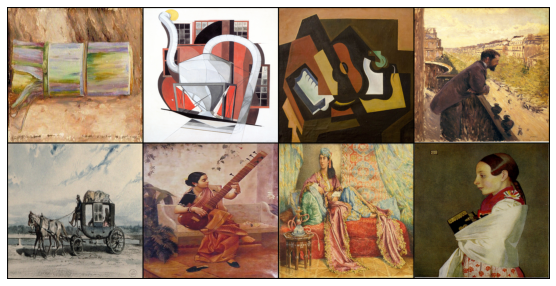

In [18]:
sample_imgs, _ = next(data)
grid_img = torchvision.utils.make_grid(sample_imgs.clamp(-1, 1).add(1).div(2), nrow=4)
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0));


# Training

Now we have the dataset.

In [19]:
wandb_run = wandb.init(project=train_cfg.wandb_project,
    entity=train_cfg.wandb_entity,
    name=train_cfg.wandb_name)

wandb: Currently logged in as: coco6. Use `wandb login --relogin` to force relogin


In [20]:
dist_util.setup_dist()

model, diffusion = create_model_and_diffusion(
    **args_to_dict(train_cfg, model_and_diffusion_defaults().keys()))
model.to(dist_util.dev())

schedule_sampler = create_named_schedule_sampler(
    train_cfg.schedule_sampler, diffusion)

In [ ]:
logger.configure(dir=train_cfg.log_dir,wandb_run=wandb_run)

try:
    TrainLoop(
    model=model,
    diffusion=diffusion,
    data=data,
    batch_size=train_cfg.batch_size,
    microbatch=train_cfg.microbatch,
    lr=train_cfg.lr,
    ema_rate=train_cfg.ema_rate,
    log_interval=train_cfg.log_interval,
    save_interval=train_cfg.save_interval,
    resume_checkpoint=train_cfg.resume_checkpoint,
    use_fp16=train_cfg.use_fp16,
    fp16_scale_growth=train_cfg.fp16_scale_growth,
    schedule_sampler=schedule_sampler,
    weight_decay=train_cfg.weight_decay,
    lr_anneal_steps=train_cfg.lr_anneal_steps,
    wandb_run=wandb_run
).run_loop()
    
except KeyboardInterrupt:
    wandb.finish()

In [27]:
!wget https://api.wandb.ai/files/sreevishnu-damodaran/clip_diffusion_art/29bag3br/256x256_clip_diffusion_art.pt -q /content/clip-diffusion-art/

We used a pretrained config on the same artworks-in-public-domain dataset as our sampling config.

In [28]:
cfg_dict = {
    "seed": 84,
    "wandb_project": "clip_diffusion_art",
    "wandb_name": "coco_2",
    "model_config": "/content/clip-diffusion-art/clip_diffusion_art/configs/256x256_clip_diffusion_art.yaml",
    "checkpoint": "/content/clip-diffusion-art/256x256_clip_diffusion_art.pt",
    "batch_size": 1,
    "skip_timesteps": 5,
    "sampling": "ddim50",
    "diffusion_steps": 1000,
    "clip_guidance_scale": 5000,
    "cutn": 60,
    "cutn_batches": 4,
    "scale_multiplier": 1,
    "tv_scale":75,
    "range_scale": 200,
    "loss_fn":"spherical",
    "clip_model": "ViT-B/16",
    "large_sr": True,
}

cfg_dict["output_dir"] = f"content/clip-diffusion-art/{cfg_dict['wandb_name']}"

cfg = SimpleNamespace(**cfg_dict)

In [29]:
seed_all(cfg.seed)
config_file = open(cfg.model_config)
model_config = yaml.load(config_file,Loader=yaml.FullLoader)["model_config"]
print("model_config", model_config)

model_config {'attention_resolutions': '16', 'class_cond': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': True, 'image_size': 256, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 128, 'num_heads': 1, 'num_res_blocks': 2, 'use_checkpoint': False, 'use_fp16': 'True,', 'use_scale_shift_norm': False}


In [30]:
clip_diffusion = ClipDiffusion(cfg.checkpoint,
    model_config=model_config,
    sampling=cfg.sampling,
    diffusion_steps=cfg.diffusion_steps,
    clip_model=cfg.clip_model,
    device=device
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth


# Generate

In [ ]:
os.makedirs(os.path.join(cfg.output_dir, 'wandb'), exist_ok=True)

wandb_run = wandb.init(project=cfg.wandb_project,
                        dir=cfg.output_dir,
                        name=cfg.wandb_name)

In [ ]:
# os.makedirs(cfg.output_dir, exist_ok=True)

# for i, out_image in enumerate(out_generator):
#     disp_image = TF.to_pil_image(out_image.squeeze(0))
#     out_image = clip_diffusion.upscale(out_image,
#                                         large_sr=cfg.large_sr)
#     out_image = TF.to_pil_image(out_image.squeeze(0))
    
#     fig, axs = plt.subplots(1, 2, figsize=(15, 18))
#     [axi.set_axis_off() for axi in axs.ravel()]
#     axs[0].imshow(disp_image)
#     axs[0].set_title("Before Super-resolution", fontsize=20)
#     axs[1].imshow(out_image)
#     axs[1].set_title("After Super-resolution", fontsize=20)
#     plt.show()
    
#     current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
#     filename = f'image{i}_{current_time}.png'
#     out_image.save(os.path.join(cfg.output_dir, filename))
    
#     if wandb_run is not None:
#         wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})

In [35]:
prompts =  ["vibrant matte painting of a house in an enchanted forest, artstation HQ"]
num_samples = 2
out_generator = clip_diffusion.sample(
                    prompts,
#                     args.images,
                    num_samples=num_samples,
                    batch_size=cfg.batch_size,
                    skip_timesteps=cfg.skip_timesteps,
#                     clip_denoised=cfg.clip_denoised,
#                     randomize_class=cfg.randomize_class,
#                     eta=cfg.eta,
#                     skip_augs=cfg.skip_augs,
                    cutn=cfg.cutn,
                    cutn_batches=cfg.cutn_batches,
#                     init_image=cf.init_image,
                    loss_fn=cfg.loss_fn,
                    clip_guidance_scale=cfg.clip_guidance_scale,
                    tv_scale=cfg.tv_scale,
                    range_scale=cfg.range_scale,
#                     saturation_scale=cfg.saturation_scale,
#                     init_scale=cfg.init_scale,
                    scale_multiplier=cfg.scale_multiplier,
                    output_dir=cfg.output_dir,
                    wandb_run=wandb_run
                )

Sample 0 : : 44step [05:07,  7.00s/step, output=0, step=43]


0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [02:49,  3.64s/step, output=0, step=43]

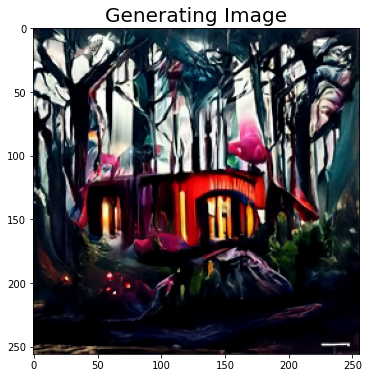

Sample 0 : : 45step [02:50,  3.78s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [02:46,  3.59s/step, output=0, step=43]

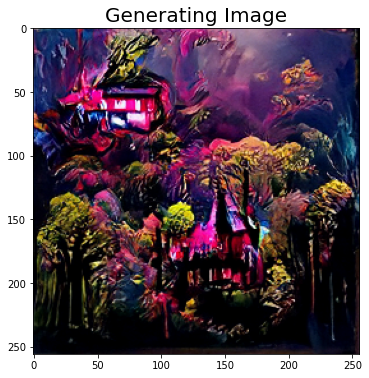

Sample 1 : : 45step [02:46,  3.71s/step, output=0, step=44]


In [36]:
os.makedirs(cfg.output_dir, exist_ok=True)

for i, out_image in enumerate(out_generator):
    # disp_image = TF.to_pil_image(out_image.squeeze(0))
    # out_image = clip_diffusion.upscale(out_image,large_sr=cfg.large_sr)
    out_image = TF.to_pil_image(out_image.squeeze(0))
    
    fig, axs = plt.subplots(figsize=(6,6))
    axs.imshow(out_image)
    axs.set_title("Generating Image", fontsize=20)
    plt.show()
    
    # current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    # filename = f'image{i}_{current_time}.png'
    # out_image.save(os.path.join(cfg.output_dir, filename))
    
    # if wandb_run is not None:
    #     wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})

0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [02:42,  3.65s/step, output=0, step=43]

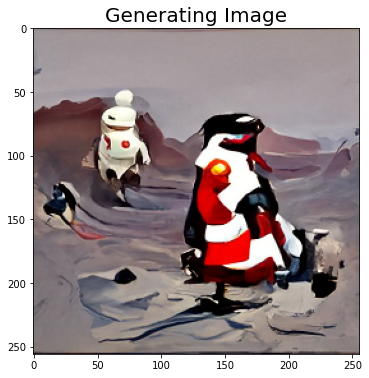

Sample 0 : : 45step [02:43,  3.63s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [02:42,  3.57s/step, output=0, step=43]

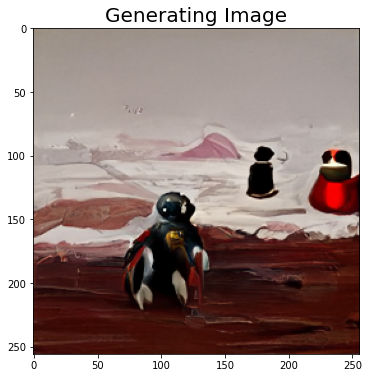

Sample 1 : : 45step [02:43,  3.63s/step, output=0, step=44]


In [37]:
prompts =  ["a penguin on Mars wearing a spacesuit walking a robot dog next to Santa Claus, artstation HQ"]
num_samples = 2
out_generator = clip_diffusion.sample(
                    prompts,
#                     args.images,
                    num_samples=num_samples,
                    batch_size=cfg.batch_size,
                    skip_timesteps=cfg.skip_timesteps,
#                     clip_denoised=cfg.clip_denoised,
#                     randomize_class=cfg.randomize_class,
#                     eta=cfg.eta,
#                     skip_augs=cfg.skip_augs,
                    cutn=cfg.cutn,
                    cutn_batches=cfg.cutn_batches,
#                     init_image=cf.init_image,
                    loss_fn=cfg.loss_fn,
                    clip_guidance_scale=cfg.clip_guidance_scale,
                    tv_scale=cfg.tv_scale,
                    range_scale=cfg.range_scale,
#                     saturation_scale=cfg.saturation_scale,
#                     init_scale=cfg.init_scale,
                    scale_multiplier=cfg.scale_multiplier,
                    output_dir=cfg.output_dir,
                    wandb_run=wandb_run
                )
os.makedirs(cfg.output_dir, exist_ok=True)

for i, out_image in enumerate(out_generator):
    #disp_image = TF.to_pil_image(out_image.squeeze(0))
    #out_image = clip_diffusion.upscale(out_image,large_sr=cfg.large_sr)
    out_image = TF.to_pil_image(out_image.squeeze(0))
    
    fig, axs = plt.subplots(figsize=(6,6))
    axs.imshow(out_image)
    axs.set_title("Generating Image", fontsize=20)
    plt.show()
    
    # current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    # filename = f'image{i}_{current_time}.png'
    # out_image.save(os.path.join(cfg.output_dir, filename))
    
    # if wandb_run is not None:
    #     wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})

0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [02:42,  3.59s/step, output=0, step=43]

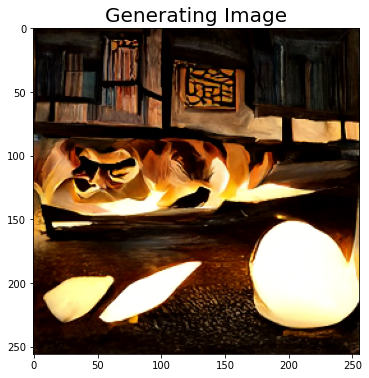

Sample 0 : : 45step [02:43,  3.63s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [02:42,  3.65s/step, output=0, step=43]

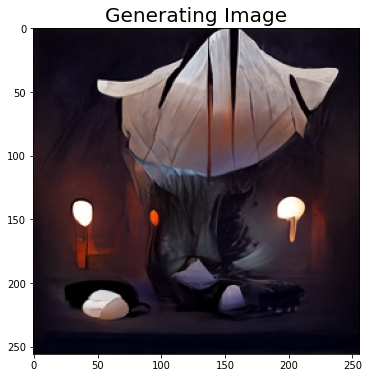

Sample 1 : : 45step [02:43,  3.63s/step, output=0, step=44]


In [38]:
prompts =  ["a cat in the street with some lanterns, artstation HQ"]
num_samples = 2
out_generator = clip_diffusion.sample(
                    prompts,
#                     args.images,
                    num_samples=num_samples,
                    batch_size=cfg.batch_size,
                    skip_timesteps=cfg.skip_timesteps,
#                     clip_denoised=cfg.clip_denoised,
#                     randomize_class=cfg.randomize_class,
#                     eta=cfg.eta,
#                     skip_augs=cfg.skip_augs,
                    cutn=cfg.cutn,
                    cutn_batches=cfg.cutn_batches,
#                     init_image=cf.init_image,
                    loss_fn=cfg.loss_fn,
                    clip_guidance_scale=cfg.clip_guidance_scale,
                    tv_scale=cfg.tv_scale,
                    range_scale=cfg.range_scale,
#                     saturation_scale=cfg.saturation_scale,
#                     init_scale=cfg.init_scale,
                    scale_multiplier=cfg.scale_multiplier,
                    output_dir=cfg.output_dir,
                    wandb_run=wandb_run
                )

os.makedirs(cfg.output_dir, exist_ok=True)

for i, out_image in enumerate(out_generator):
    #disp_image = TF.to_pil_image(out_image.squeeze(0))
    #out_image = clip_diffusion.upscale(out_image,large_sr=cfg.large_sr)
    out_image = TF.to_pil_image(out_image.squeeze(0))
    
    fig, axs = plt.subplots(figsize=(6,6))
    axs.imshow(out_image)
    axs.set_title("Generating Image", fontsize=20)
    plt.show()
    
    # current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    # filename = f'image{i}_{current_time}.png'
    # out_image.save(os.path.join(cfg.output_dir, filename))
    
    # if wandb_run is not None:
        # wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})

0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [02:41,  3.58s/step, output=0, step=43]

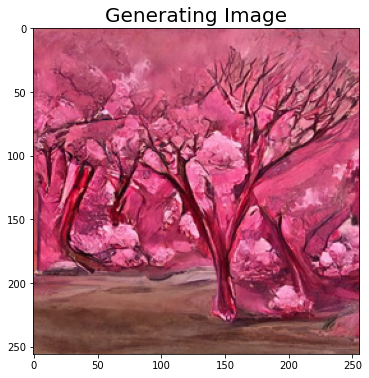

Sample 0 : : 45step [02:42,  3.60s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [02:41,  3.57s/step, output=0, step=43]

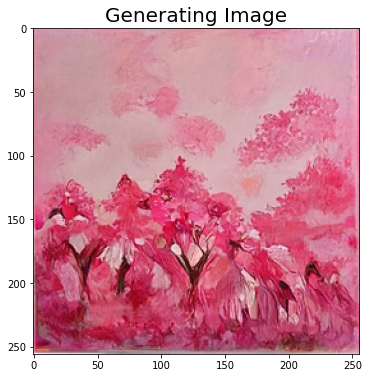

Sample 1 : : 45step [02:42,  3.61s/step, output=0, step=44]


In [39]:
prompts =  ["a painting of pink sakura trees, HQ"]
num_samples = 2
out_generator = clip_diffusion.sample(
                    prompts,
#                     args.images,
                    num_samples=num_samples,
                    batch_size=cfg.batch_size,
                    skip_timesteps=cfg.skip_timesteps,
#                     clip_denoised=cfg.clip_denoised,
#                     randomize_class=cfg.randomize_class,
#                     eta=cfg.eta,
#                     skip_augs=cfg.skip_augs,
                    cutn=cfg.cutn,
                    cutn_batches=cfg.cutn_batches,
#                     init_image=cf.init_image,
                    loss_fn=cfg.loss_fn,
                    clip_guidance_scale=cfg.clip_guidance_scale,
                    tv_scale=cfg.tv_scale,
                    range_scale=cfg.range_scale,
#                     saturation_scale=cfg.saturation_scale,
#                     init_scale=cfg.init_scale,
                    scale_multiplier=cfg.scale_multiplier,
                    output_dir=cfg.output_dir,
                    wandb_run=wandb_run
                )

os.makedirs(cfg.output_dir, exist_ok=True)

for i, out_image in enumerate(out_generator):
    #disp_image = TF.to_pil_image(out_image.squeeze(0))
    #out_image = clip_diffusion.upscale(out_image,large_sr=cfg.large_sr)
    out_image = TF.to_pil_image(out_image.squeeze(0))
    
    fig, axs = plt.subplots(figsize=(6,6))
    axs.imshow(out_image)
    axs.set_title("Generating Image", fontsize=20)
    plt.show()
    
    # current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    # filename = f'image{i}_{current_time}.png'
    # out_image.save(os.path.join(cfg.output_dir, filename))
    
    # if wandb_run is not None:
    #     wandb.log({os.path.splitext(filename)[0]: wandb.Image(os.path.join(cfg.output_dir, filename))})